In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""Main script used for training."""
from tensorflow.keras.callbacks import TensorBoard, CSVLogger
from tensorflow.keras.models import load_model
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from nmp import model as mod
from nmp import dataset, ev_metrics
from nmp.dataset import pyplot_piano_roll
from pathlib import Path
from nmp import plotter
import time
import math
import pypianoroll
from pypianoroll import Multitrack, Track
import numpy as np
import copy
import tensorflow as tf

# P = Path(__file__).parent.absolute()
P = Path(os.path.abspath(''))  # Compatible with Jupyter Notebook

PLOTS = P / 'plots'  # Plots path
FS = 24  # Sampling frequency. 10 Hz = 100 ms
# Q = 0  # Quantize?
st = 10  # Past timesteps
num_ts = 10  # Predicted timesteps
DOWN = 12
# D = "data/Piano-Midi.de"  # Dataset
# D = "data/Nottingham"  # Dataset
D = "data/JSB Chorales"  # Dataset
CROP = [21, 109]  # Crop plots
TRANS = 0

# Many notes (64)
LOW_LIM = 33  # A1
HIGH_LIM = 97  # C7

# Few notes
# LOW_LIM = 36  # C2
# HIGH_LIM = 85  # C6

# Complete 88-key keyboard
# LOW_LIM = 21  # A0
# HIGH_LIM = 109  # C8

NUM_NOTES = HIGH_LIM - LOW_LIM
CROP = [LOW_LIM, HIGH_LIM]  # Crop plots

VIEW_ROLLS = 0

Using TensorFlow backend.


### Load model

In [2]:
FF = 1
BS = 64
if FF:
    checkpoint_dir = P / ('models/take/ff-jsb')
    model_ff = mod.build_model((st, NUM_NOTES), (num_ts), NUM_NOTES, BS)
    mod.compile_model(model_ff, 'binary_crossentropy', 'adam',
                      metrics=['accuracy', mod.f1])
    model_ff.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
    model_ff.build(tf.TensorShape([1, None]))
    model_ff.summary()
    model = model_ff
else:
    checkpoint_dir = P / ('models/take/lstm-jsb')
    model = mod.build_gru_model(NUM_NOTES, 1)
    mod.compile_model(model, 'binary_crossentropy', 'adam',
                      metrics=['accuracy'])
    model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
    model.build(tf.TensorShape([1, None]))
    model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10, 32)            2080      
_________________________________________________________________
flatten (Flatten)            (None, 320)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                10272     
_________________________________________________________________
Output (Dense)               (None, 640)               21120     
Total params: 33,472
Trainable params: 33,472
Non-trainable params: 0
_________________________________________________________________


### Load midi file

In [3]:
if FF:
    FILE = 'bach-minuetto1.mid'
    test_list = [P / 'midi_tests' / FILE]

    midi_list = [x for x in os.listdir(P / D / 'test') if x.endswith('.mid')]
    test_list = midi_list
    # test_list = midi_list[213:236]

    print("Total number of MIDI files:", len(test_list))
    test = dataset.Dataset(test_list, P / D / 'test',  fs=FS, bl=0)
    test.build_dataset("test", step=st, t_step=num_ts, steps=st,
                       down=DOWN, low_lim=LOW_LIM, high_lim=HIGH_LIM)
    print("Done")
    print("Shape: ", test.dataset[0].shape)

else:
    
    def split_input_target(chunk):
        input_text = chunk[:, :10*64]
        target_text = chunk[:, 10*64:]
        return input_text, target_text

    def split_input_target_base(chunk):
        input_text = chunk[:,:10]
        target_text = chunk[:,10:]
        return input_text, target_text

    test_list = [x for x in os.listdir(P / D / 'test') if x.endswith('.mid')]
    test = dataset.Dataset(test_list, P / D / 'test',  fs=FS, bl=0, quant=0)
    test.build_rnn_dataset("test", down=DOWN, low_lim=LOW_LIM, high_lim=HIGH_LIM)
    test_dataset = tf.data.Dataset.from_tensor_slices((test.dataset[0]))
    test_sequences = test_dataset.batch(50, drop_remainder=True)
    test_data = test_sequences.map(split_input_target)
    test_data = test_data.batch(1, drop_remainder=True)

Total number of MIDI files: 77
Building test dataset (77 files)
Done
Shape:  (8503, 10, 64)


### Make predictions

In [5]:
if FF:
    L = test.dataset[0].shape[0]
    predictions = model.predict(x=test.dataset[0][:L, :, :])

else:
    model.reset_states()
    predauc = []
    baseauc = []

    merged_input = []
    merged_output = []
    merged_pred = []

    for input_batch, label_batch in test_data.take(-1):
        predictions = model(tf.cast(input_batch, tf.float32))

        pred = np.array(tf.squeeze(predictions, 0))

        inp = np.array(tf.squeeze(input_batch, 0))
        out = np.array(tf.squeeze(label_batch, 0))

        # Merged piano rolls to compute overall AUC.
        merged_input.append(inp)
        merged_output.append(out)
        merged_pred.append(pred)

    merged_input = np.concatenate([x for x in merged_input])
    merged_output = np.concatenate([x for x in merged_output])
    merged_pred = np.concatenate([x for x in merged_pred])

    print(merged_input.shape)

    baseline = copy.deepcopy(merged_input)
    for t in range(len(merged_input)):
        for s in range(10):
            baseline[t, 64*s:64*(s+1)] = merged_input[t, 640-64:640]

### Build baseline

In [6]:
if FF:
    baseline = dataset.Dataset(test_list, P / D / 'test',  fs=FS, bl=1)
    baseline.build_dataset("baseline", step=st, t_step=num_ts, steps=st,
                           down=DOWN, low_lim=LOW_LIM, high_lim=HIGH_LIM)

Building baseline dataset (77 files)


### Make piano rolls

In [ ]:
newpiano = copy.deepcopy(predictions)
L = int(predictions.shape[1]/NUM_NOTES)
for t in range(L):
    newpiano[newpiano.shape[0]-L+t, :NUM_NOTES] = predictions[newpiano.shape[0]-L, NUM_NOTES*t:NUM_NOTES*(t+1)]
    
a = copy.deepcopy(test.dataset[1][:, :])
L = int(test.dataset[1][:, :].shape[1]/NUM_NOTES)
for t in range(L):
    a[a.shape[0]-L+t, :NUM_NOTES] = test.dataset[1][a.shape[0]-L, NUM_NOTES*t:NUM_NOTES*(t+1)]
    
a = pd.DataFrame(test.dataset[0][:, 0, :])
b = pd.DataFrame(newpiano[-num_ts:, :NUM_NOTES])
b2 = pd.DataFrame(test.dataset[1][-num_ts:, :NUM_NOTES])

c = pd.concat([a, b]).values
d = pd.concat([a, b2]).values

### Visualise piano rolls

In [ ]:
# th = 0.16
import importlib
importlib.reload(dataset)
C = copy.deepcopy(c)
# C[C > th] = 1
# C[C < th] = 0

C = dataset.ranked_threshold(c, steps=1, how_many=8)

plt.rcParams["figure.figsize"] = (8, 4)
ax1 = pyplot_piano_roll(d, cmap="Greens", db=[d.shape[0]-L-0.5], br=2,
                        low_lim=LOW_LIM, high_lim=HIGH_LIM)
plt.title('Real')
plt.ylim(LOW_LIM, HIGH_LIM)
# plt.xlim([50, 71])
plt.ylim(55, 75)
# plt.savefig(PLOTS / 'bach846' / 'real.eps')

if VIEW_ROLLS:
    pyplot_piano_roll(c, cmap="Oranges", db=[d.shape[0]-L-0.5], br=2,
                      low_lim=LOW_LIM, high_lim=HIGH_LIM)
    plt.title('Prediction (not thresholded)')
    plt.ylim(LOW_LIM, HIGH_LIM)
    # plt.xlim([50, 71])
    plt.ylim(55, 75)
    # plt.savefig(PLOTS / 'bach846' / 'not-thresh.eps')

    pyplot_piano_roll(C, cmap="Reds", db=[d.shape[0]-L-0.5], br=2,
                      low_lim=LOW_LIM, high_lim=HIGH_LIM)
    plt.title('Prediction (thresolded)')
    plt.ylim(LOW_LIM, HIGH_LIM)
    # plt.xlim([50, 71])
    plt.ylim(55, 75)
    # plt.savefig(PLOTS / 'bach846' / 'thresh.eps')

### Evaluate AUC - ROC
Evaluate metric on predictions and baseline with respect to the ground truth of test dataset

In [ ]:
# Build baseline
# baseline = dataset.Dataset(test_list, P / D / 'test',  fs=FS, bl=1)
# baseline.build_dataset("baseline", step=st, t_step=num_ts, steps=st,
#                        down=DOWN, low_lim=LOW_LIM, high_lim=HIGH_LIM)

# x = baseline.dataset[0][:16544, :, :]
# y = baseline.dataset[1][:16544, :]
# baseline.dataset = (x, y)

# print("")
# print("Baseline shape: ", baseline.dataset[1].shape)
# print("Test shape: ", test.dataset[1].shape)

if FF:
    pred_auc = ev_metrics.compute_auc(test.dataset[1], predictions, NUM_NOTES)
    base_auc = ev_metrics.compute_auc(test.dataset[1], baseline.dataset[1], NUM_NOTES)
else:
    pred_auc = ev_metrics.compute_auc(merged_output, merged_pred, NUM_NOTES)
    base_auc = ev_metrics.compute_auc(merged_output, baseline, NUM_NOTES)

In [ ]:
fig, (ax1, ax2, axcb) = plt.subplots(1, 3, constrained_layout=True,
                                     figsize=(8, 8),
                                     gridspec_kw={'width_ratios':[1, 1, 0.08]})
g1 = sns.heatmap(pred_auc, vmin=0.5, vmax=1, cmap='copper', ax=ax1, cbar=False)
g1.set_ylabel('')
g1.set_xlabel('')
g1.set_yticklabels(g1.get_yticklabels(), rotation=0)
ax1.set_xlabel('Time (step)')
ax1.set_ylabel('Pitch')
ax1.set_title('AUC-ROC (prediction)')
g2 = sns.heatmap(base_auc, vmin=0.5, vmax=1, cmap='copper', ax=ax2, cbar_ax=axcb)
g2.set_ylabel('')
g2.set_xlabel('')
g2.set_yticks([])
ax2.set_xlabel('Time (step)')
ax2.set_title('AUC-ROC (baseline)')
ax1.get_shared_y_axes().join(ax1,ax2)
# plt.savefig(PLOTS / 'heat.eps', format='eps')
print(pred_auc.shape)

In [ ]:
c1 = 0
c2 = 64
fig, (ax1, ax2, axcb) = plt.subplots(1, 3, constrained_layout=True,
                                     figsize=(8, 6),
                                     gridspec_kw={'width_ratios':[1, 1, 0.08]})
g1 = sns.heatmap(pred_auc[c1:c2], vmin=0.5, vmax=1, cmap='gray', ax=ax1, cbar=False)
g1.set_ylabel('')
g1.set_xlabel('')
g1.set_yticklabels(g1.get_yticklabels(), rotation=0)
ax1.set_xlabel('Time (step)')
ax1.set_ylabel('Pitch')
ax1.set_title('AUC-ROC (crop) [prediction]')
g2 = sns.heatmap(base_auc[c1:c2], vmin=0.5, vmax=1, cmap='gray', ax=ax2, cbar_ax=axcb)
g2.set_ylabel('')
g2.set_xlabel('')
g2.set_yticks([])
ax2.set_xlabel('Time (step)')
ax2.set_title('AUC-ROC (crop) [baseline]')
ax1.get_shared_y_axes().join(ax1,ax2)
# plt.savefig(PLOTS / 'heat_crop.eps', format='eps')
print(pred_auc.shape)

In [ ]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(5, 4))

ax.plot(range(1, num_ts + 1), np.mean(pred_auc[c1:c2]), 'x', c='tab:blue', label='prediction', ms=10)
ax.plot(range(1, num_ts + 1), np.mean(base_auc[c1:c2]), 'o', c='tab:green', label='baseline ', ms=7)

ax.set_ylim([0.4, 1])
ax.set_ylim([0.4, 1])
ax.legend()
plt.title('Avg. AUC-ROC per predicted timestep')
plt.xlabel('Timestep')
# plt.xticks([0, 2, 4, 6, 8, 10])
plt.ylabel('ROC AUC')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
name = 'auc' + str()
plt.grid()
# plt.savefig(PLOTS / 'auc.eps', format='eps')

print("Predict. mean value:", np.mean(np.mean(pred_auc[c1:c2])))
print("Baseline mean value:", np.mean(np.mean(base_auc[c1:c2])))

In [ ]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(5, 4))

ax.plot(range(1, num_ts + 1), np.mean(pred_auc[c1:c2]), 'x', c='tab:blue', label='prediction', ms=10)
ax.plot(range(1, num_ts + 1), np.mean(base_auc[c1:c2]), 'o', c='tab:green', label='baseline ', ms=7)

ax.set_ylim([0.4, 1])
ax.set_ylim([0.4, 1])
ax.legend()
plt.title('Avg. AUC-ROC per predicted timestep')
plt.xlabel('Timestep')
# plt.xticks([0, 2, 4, 6, 8, 10])
plt.ylabel('ROC AUC')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
name = 'auc' + str()
# plt.savefig(PLOTS / 'auc.eps', format='eps')

print("Predict. mean value:", np.mean(np.mean(pred_auc[c1:c2])))
print("Baseline mean value:", np.mean(np.mean(base_auc[c1:c2])))

In [ ]:
pd.DataFrame(predictions)

In [ ]:
# T = 50
# print(predictions[T, :].shape)
# my_roll = np.reshape(predictions[T, :], (10, 64))
# for t in range(len(my_roll)):
#     my_roll[t, :].sort()

# np.reshape(my_roll, (640,))

In [ ]:
# predictions[t, :].shape

In [ ]:
# for t in range(len(predictions)):
#     predictions[t, :] = dataset.sort_piano_roll(predictions[t, :], 10)

In [ ]:
print(predictions.shape)

In [ ]:
print(dataset.pad_piano_roll(c, LOW_LIM, HIGH_LIM))

## Save MIDI file

In [ ]:
# f = copy.deepcopy(C)
# f[f > 0] = 127
# traccia = pypianoroll.Track(dataset.pad_piano_roll(f, LOW_LIM, HIGH_LIM))
# multitraccia = pypianoroll.Multitrack(tracks=[traccia], tempo=120.0, beat_resolution=2)
# multitraccia.write('./traccia.mid')

## Dissonance perception metric

In [7]:
# test.dataset[0][:, 9, :].shape

In [8]:
# Hold baseline
if FF:
    hold_baseline = test.dataset[0][:, 9, :]
    hold_baseline.shape
    
else:
    hold_baseline = copy.deepcopy(baseline)
    predictions = copy.deepcopy(merged_pred)

(8503, 640)


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12aa43841c8>)

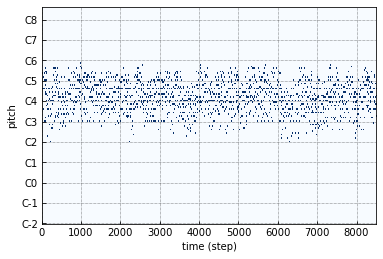

In [9]:
print(test.dataset[1].shape)
pyplot_piano_roll(test.dataset[1][:, :64], low_lim=LOW_LIM, high_lim=HIGH_LIM)

(8503, 640)


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12aa434b048>)

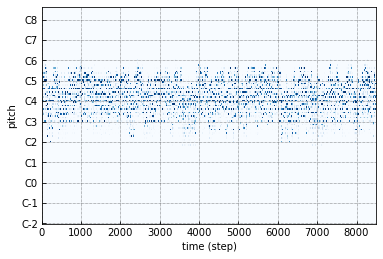

In [10]:
print(predictions.shape)
pyplot_piano_roll(predictions[:, :64], low_lim=LOW_LIM, high_lim=HIGH_LIM)

(8503, 64)


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12aaaf55108>)

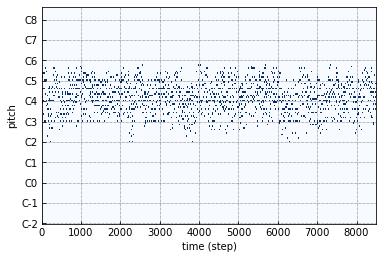

In [11]:
print(hold_baseline.shape)
pyplot_piano_roll(hold_baseline[:, :64], low_lim=LOW_LIM, high_lim=HIGH_LIM)

In [12]:
# print(merged_input.shape)
# pyplot_piano_roll(merged_input[:, :64], low_lim=LOW_LIM, high_lim=HIGH_LIM)
# pyplot_piano_roll(hold_baseline[:, :64], low_lim=LOW_LIM, high_lim=HIGH_LIM)

In [13]:
predictions_bin = []

for timestep in range(10):
    pb = []
    if FF:
        search, _ = dataset.get_indexes(test.dataset[1][:, 64*timestep:64*(timestep+1)])
    else:
        search, _ = dataset.get_indexes(merged_output[:, 64*timestep:64*(timestep+1)])
    number_of_notes = [len(n) for n in search]
    
    for cnt, n in enumerate(number_of_notes):
        pb.append(dataset.ranked_threshold(predictions[cnt:cnt+1, 64*timestep:64*(timestep+1)],
                                                        how_many=n,
                                                        steps=1))
    predictions_bin.append(np.array(pb)[:, 0, :])
predictions_bin = np.array(predictions_bin)

In [14]:
# print(predictions_bin.shape)

# pyplot_piano_roll(predictions_bin[:, 0, :], low_lim=LOW_LIM, high_lim=HIGH_LIM)

In [15]:
print(predictions.shape)
print(predictions_bin.shape)
# predictions_bin2 = np.reshape(predictions_bin, (16544, 640))
# print(predictions_bin2.shape)
print(hold_baseline.shape)
# print(merged_input.shape)
print(test.dataset[1].shape)

(8503, 640)
(10, 8503, 64)
(8503, 64)
(8503, 640)


In [16]:
# pyplot_piano_roll(predictions_bin2[:, 64*5:64*6], low_lim=LOW_LIM, high_lim=HIGH_LIM)

In [17]:
# from nmp import ev_metrics
# import importlib
# importlib.reload(ev_metrics)
# for a in range(10):
#     values = ev_metrics.dissonance_perception(test.dataset[1][:, a*64:(a+1)*64], predictions_bin[a, :, :])
#     print("Perceptive accuracy at timesteps %d: %.2f%%" % (a, values))

#     base_values = ev_metrics.dissonance_perception(test.dataset[1][:, a*64:(a+1)*64], hold_baseline[:, :64])
#     print("Baseline perceptive accuracy: %.2f%%" % base_values)

# #     test_values = ev_metrics.dissonance_perception(test.dataset[1][:, a*64:(a+1)*64], test.dataset[1][:, a*64:(a+1)*64])
# #     print("Self-test perceptive accuracy: %.2f%%" % test_values)

In [18]:
from nmp import ev_metrics
import importlib
importlib.reload(ev_metrics)
diss_pred = []
diss_base = []
for a in range(10):
    if FF:
        values = ev_metrics.dissonance_perception(test.dataset[1][:, a*64:(a+1)*64], predictions_bin[a, :, :])
    else:
        values = ev_metrics.dissonance_perception(merged_output[:, a*64:(a+1)*64], predictions_bin[a, :, :])
    diss_pred.append(values)
    print("Perceptive accuracy at timesteps %d: %.2f%%" % (a, values))

    if FF:
        base_values = ev_metrics.dissonance_perception(test.dataset[1][:, a*64:(a+1)*64], hold_baseline[:, -64:])
    else:
#         base_values = ev_metrics.dissonance_perception(merged_output[:, a*64:(a+1)*64], hold_baseline[:, a*64:(a+1)*64])
        base_values = ev_metrics.dissonance_perception(merged_output[:, a*64:(a+1)*64], merged_input[:, -64:])
    diss_base.append(base_values)
    print("Baseline perceptive accuracy: %.2f%%" % base_values)
    print()

#     test_values = ev_metrics.dissonance_perception(test.dataset[1][:, a*64:(a+1)*64], test.dataset[1][:, a*64:(a+1)*64])
#     print("Self-test perceptive accuracy: %.2f%%" % test_values)

Perceptive accuracy at timesteps 0: 0.25%
Baseline perceptive accuracy: 0.24%

Perceptive accuracy at timesteps 1: 0.25%
Baseline perceptive accuracy: 0.23%

Perceptive accuracy at timesteps 2: 0.26%
Baseline perceptive accuracy: 0.23%

Perceptive accuracy at timesteps 3: 0.26%
Baseline perceptive accuracy: 0.24%

Perceptive accuracy at timesteps 4: 0.26%
Baseline perceptive accuracy: 0.25%

Perceptive accuracy at timesteps 5: 0.26%
Baseline perceptive accuracy: 0.26%

Perceptive accuracy at timesteps 6: 0.26%
Baseline perceptive accuracy: 0.26%

Perceptive accuracy at timesteps 7: 0.26%
Baseline perceptive accuracy: 0.27%

Perceptive accuracy at timesteps 8: 0.26%
Baseline perceptive accuracy: 0.27%

Perceptive accuracy at timesteps 9: 0.27%
Baseline perceptive accuracy: 0.27%



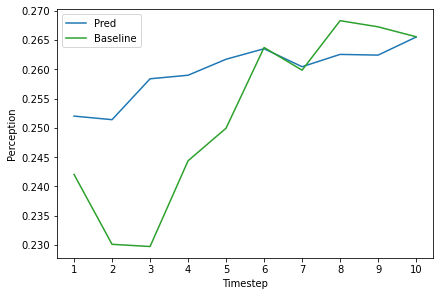

In [19]:
plt.figure(constrained_layout=True)
plt.plot(range(1, 11), diss_pred, label='Pred', color='tab:blue')
plt.plot(range(1, 11), diss_base, label='Baseline', color='tab:green')
# plt.ylim(0, 1)
plt.xticks(range(1, 11))
plt.ylabel("Perception")
plt.xlabel("Timestep")
plt.legend()

In [ ]:
tocsv = pd.DataFrame({'timestep': range(1, 11), 'pred': diss_pred, 'base': diss_base})
tocsv = tocsv.set_index('timestep')

In [ ]:
tocsv['pred'].to_csv(('tables/dissonance-' + D[5:] + '-pred.dat').lower(), sep=' ', header=None)
tocsv['base'].to_csv(('tables/dissonance-' + D[5:] + '-base.dat').lower(), sep=' ', header=None)

In [ ]:
# from nmp import ev_metrics
# import importlib
# importlib.reload(ev_metrics)
# values = ev_metrics.dissonance_perception(pd.DataFrame(d).tail(10),
#                                           pd.DataFrame(C).tail(10))
# print("Perceptive accuracy: %.2f%%" % values)

# base_values = ev_metrics.dissonance_perception(pd.DataFrame(d).tail(10),
#                                                pd.DataFrame(hold_baseline).tail(10))
# print("Baseline perceptive accuracy: %.2f%%" % base_values)

In [ ]:
if VIEW_ROLLS:
    plt.rcParams["figure.figsize"] = (8, 4)
    ax1 = pyplot_piano_roll(d, cmap="Greens", db=[d.shape[0]-L-0.5], br=2,
                            low_lim=LOW_LIM, high_lim=HIGH_LIM)
    plt.title('Real')
    plt.ylim(LOW_LIM, HIGH_LIM)

    pyplot_piano_roll(C, cmap="Reds", db=[d.shape[0]-L-0.5], br=2,
                      low_lim=LOW_LIM, high_lim=HIGH_LIM)
    plt.title('Prediction (ranked thresold)')
    plt.ylim(LOW_LIM, HIGH_LIM)

    pyplot_piano_roll(hold_baseline, cmap="Reds", db=[d.shape[0]-L-0.5], br=2,
                      low_lim=LOW_LIM, high_lim=HIGH_LIM)
    plt.title('Baseline')
    plt.ylim(LOW_LIM, HIGH_LIM)